In [1]:
import copy
import datetime
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 시각화
import seaborn as sns
# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import cluster


# 데이터 불러오기

In [2]:
data_df = pd.read_excel('milk_preprocessing_outlier.xlsx')
data_df

,Unnamed: 0,index,거주지,가입경로,담당사원,상품코드,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y,재구매여부,부모연령,포인트사용여부
0,0,3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46,130,0,2,0
1,1,4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46,96,0,1,0
2,2,6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100,96,0,2,0
3,3,16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46,160,0,1,0
4,4,21,세종특별자치시,H,박애신,89002,16,10.0,8,221400,101400,120000,46,96,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,19530,24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73,161,0,1,0
19531,19531,24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43,96,0,1,0
19532,19532,24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79,130,0,1,0
19533,19533,24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73,130,0,1,0


In [3]:
del data_df['Unnamed: 0']
del data_df['index']

In [4]:
data_df.rename(columns={'상담횟수_y':'총상담횟수', '총구매횟수_y':'총구매횟수',\
                        '총구매수량_y':'총구매수량','총구매금액_y':'총구매금액',\
                        '총할인금액_y':'총할인금액','최종결제금액_y':'최종결제금액',\
                        '할인율_y':'할인율','잔여포인트_y':'잔여포인트'}, inplace=True)

In [5]:
data_df.head()

,거주지,가입경로,담당사원,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,재구매여부,부모연령,포인트사용여부
0,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46,130,0,2,0
1,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46,96,0,1,0
2,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100,96,0,2,0
3,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46,160,0,1,0
4,세종특별자치시,H,박애신,89002,16,10.0,8,221400,101400,120000,46,96,0,1,0


<AxesSubplot:>

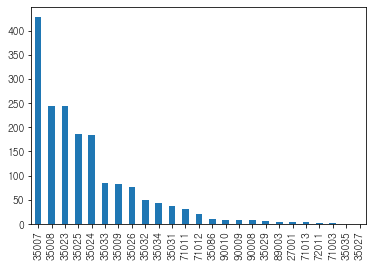

In [6]:
a = data_df[data_df['재구매여부'] == 1]
a['상품코드'].value_counts().plot(kind='bar')

In [7]:
a.count()

거주지        1772
가입경로       1772
담당사원       1772
상품코드       1772
총상담횟수      1772
총구매횟수      1772
총구매수량      1772
총구매금액      1772
총할인금액      1772
최종결제금액     1772
할인율        1772
잔여포인트      1772
재구매여부      1772
부모연령       1772
포인트사용여부    1772
dtype: int64

In [8]:
a['부모연령'].value_counts()

1    1659
2      63
0      50
Name: 부모연령, dtype: int64

In [9]:
data_df['재구매여부'].value_counts()

0    17763
1     1772
Name: 재구매여부, dtype: int64

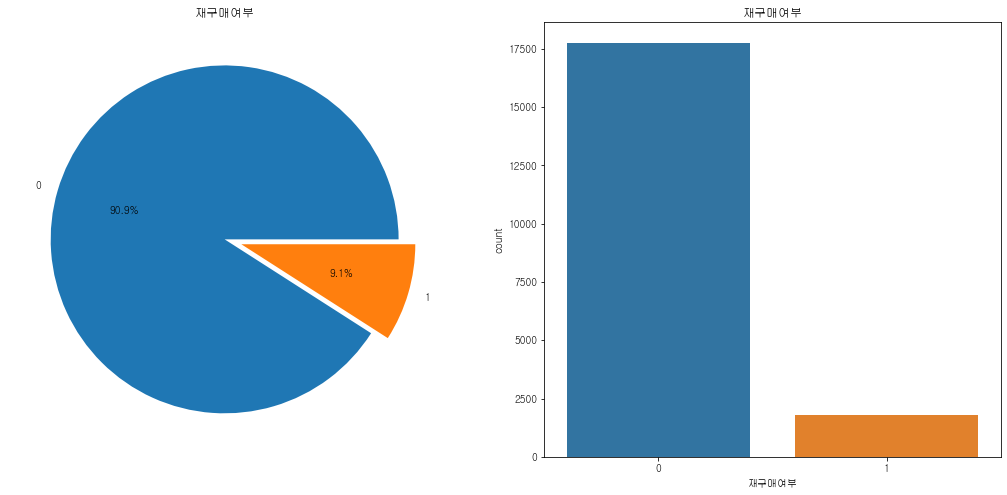

In [10]:
# 전처리와 이상치 제거 후 데이터가 줄어듬에 따라 클래스 비율이 더 극대화되었다.
f, ax = plt.subplots(1,2,figsize=(18,8))
data_df['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = data_df, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

# 학습데이터와 타겟데이터 분리

In [12]:
data_df_temp = data_df.copy()

In [13]:
y_data=data_df_temp[["재구매여부"]].copy()
x_data=data_df_temp.copy()
del x_data["재구매여부"]

In [14]:
x_data

,거주지,가입경로,담당사원,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,부모연령,포인트사용여부
0,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46,130,2,0
1,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46,96,1,0
2,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100,96,2,0
3,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46,160,1,0
4,세종특별자치시,H,박애신,89002,16,10.0,8,221400,101400,120000,46,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73,161,1,0
19531,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43,96,1,0
19532,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79,130,1,0
19533,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73,130,1,0


# Train - Test split (비율 7:3 , seed는 0을 적용)

In [15]:
x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(13674, 14)
(5861, 14)
(13674, 1)
(5861, 1)


# Data Scaling

## 범주형컬럼 one-hot encoding

### X Train Data

In [17]:
# x train data 범주형
train_x_data_categorical = x_train[["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"]]

In [18]:
encoder = OneHotEncoder(sparse=False)

# x train data는 학습과 transform 모두 적용
train_x_data_categorical = pd.DataFrame(encoder.fit_transform(train_x_data_categorical[["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"]]))
# 컬럼명 변경
train_x_data_categorical.columns = encoder.get_feature_names(["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"])

### X Test Data

In [19]:
test_x_data_categorical = x_test[["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"]]

In [20]:
# x test data는 학습은하면 안됨(정답을 훔쳐보는것) transform만 적용
test_x_data_categorical = pd.DataFrame(encoder.transform(test_x_data_categorical[["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"]]))
# 컬럼명 변경
test_x_data_categorical.columns = encoder.get_feature_names(["거주지","가입경로","담당사원","상품코드","부모연령","포인트사용여부"])

In [21]:
np.shape(train_x_data_categorical)

(13674, 92)

In [22]:
np.shape(test_x_data_categorical)

(5861, 92)

## 연속형 컬럼 Standardization

In [23]:
train_x_data_num = x_train[['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
                            '최종결제금액','할인율','잔여포인트']]

In [24]:
std_scaler=StandardScaler()
train_x_data_num = pd.DataFrame(std_scaler.fit_transform(train_x_data_num[['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
'최종결제금액','할인율','잔여포인트']]))

In [25]:
train_x_data_num.columns = ['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
                            '최종결제금액','할인율','잔여포인트']

In [26]:
train_x_data_num

,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,1.402764,2.193244,2.865522,2.681027,2.026538,2.835926,-1.861786,1.205882
1,0.041857,-0.881829,-0.511210,-0.350592,-0.123786,-0.439758,0.519805,0.618589
2,-0.346973,0.847900,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,1.186937
3,-0.346973,-0.881829,-0.511210,-0.475094,-0.373824,-0.495278,1.115203,-0.025540
4,1.986009,2.193244,0.389252,0.106174,-0.289720,0.293107,-2.031900,0.618589
...,...,...,...,...,...,...,...,...
13669,0.236273,-0.881829,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,0.618589
13670,-0.541388,-0.881829,-0.511210,-0.423737,-0.223801,-0.495278,1.115203,1.205882
13671,0.041857,0.847900,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,1.186937
13672,-0.346973,-0.881829,-0.511210,-0.350592,-0.123786,-0.439758,0.519805,-0.025540


In [27]:
test_x_data_num = x_test[['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
                            '최종결제금액','할인율','잔여포인트']]

In [28]:
std_scaler=StandardScaler()
test_x_data_num = pd.DataFrame(std_scaler.fit_transform(test_x_data_num[['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
                            '최종결제금액','할인율','잔여포인트']]))

In [29]:
test_x_data_num.columns = ['총상담횟수','총구매횟수', '총구매수량','총구매금액','총할인금액',\
                            '최종결제금액','할인율','잔여포인트']

In [30]:
test_x_data_num

,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,-0.338661,-0.880288,-0.274684,-0.494727,-0.433418,-0.496053,1.122007,0.004872
1,-0.731981,-0.880288,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,0.004872
2,1.431280,0.874731,0.190276,0.402977,0.637928,0.259442,-1.044271,-1.791369
3,-0.142001,-0.880288,-0.507164,-0.526070,-0.522888,-0.496053,1.122007,-0.462899
4,-0.338661,0.874731,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,0.641040
...,...,...,...,...,...,...,...,...
5856,-0.338661,-0.880288,-0.507164,-0.526070,-0.591712,-0.461184,0.212170,0.641040
5857,-0.142001,-0.880288,-0.507164,-0.342029,-0.112244,-0.437938,0.515449,0.004872
5858,-0.142001,-0.880288,-0.507164,-0.486690,-0.479300,-0.461184,0.428798,-0.462899
5859,-0.535321,0.874731,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,-1.791369


In [31]:
x_train = pd.concat([train_x_data_categorical, train_x_data_num], axis=1)
x_train

,거주지_강원도,거주지_경기도,거주지_경상남도,거주지_경상북도,거주지_광주광역시,거주지_대구광역시,거주지_대전광역시,거주지_부산광역시,거주지_서울특별시,거주지_세종특별자치시,...,포인트사용여부_0,포인트사용여부_1,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.402764,2.193244,2.865522,2.681027,2.026538,2.835926,-1.861786,1.205882
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.041857,-0.881829,-0.511210,-0.350592,-0.123786,-0.439758,0.519805,0.618589
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.346973,0.847900,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,1.186937
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,-0.346973,-0.881829,-0.511210,-0.475094,-0.373824,-0.495278,1.115203,-0.025540
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.986009,2.193244,0.389252,0.106174,-0.289720,0.293107,-2.031900,0.618589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.236273,-0.881829,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,0.618589
13670,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.541388,-0.881829,-0.511210,-0.423737,-0.223801,-0.495278,1.115203,1.205882
13671,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.041857,0.847900,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,1.186937
13672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-0.346973,-0.881829,-0.511210,-0.350592,-0.123786,-0.439758,0.519805,-0.025540


In [32]:
x_test = pd.concat([test_x_data_categorical, test_x_data_num], axis=1)
x_test

,거주지_강원도,거주지_경기도,거주지_경상남도,거주지_경상북도,거주지_광주광역시,거주지_대구광역시,거주지_대전광역시,거주지_부산광역시,거주지_서울특별시,거주지_세종특별자치시,...,포인트사용여부_0,포인트사용여부_1,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.338661,-0.880288,-0.274684,-0.494727,-0.433418,-0.496053,1.122007,0.004872
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.731981,-0.880288,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,0.004872
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.431280,0.874731,0.190276,0.402977,0.637928,0.259442,-1.044271,-1.791369
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.142001,-0.880288,-0.507164,-0.526070,-0.522888,-0.496053,1.122007,-0.462899
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.338661,0.874731,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,0.641040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,-0.338661,-0.880288,-0.507164,-0.526070,-0.591712,-0.461184,0.212170,0.641040
5857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,-0.142001,-0.880288,-0.507164,-0.342029,-0.112244,-0.437938,0.515449,0.004872
5858,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.142001,-0.880288,-0.507164,-0.486690,-0.479300,-0.461184,0.428798,-0.462899
5859,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.535321,0.874731,-0.507164,-0.486690,-0.525183,-0.437938,-0.004457,-1.791369


In [33]:
# x_train.to_excel('x_train.xlsx')
# x_test.to_excel('x_test.xlsx')
# y_train.to_excel('y_train.xlsx')
# y_test.to_excel('y_test.xlsx')

<AxesSubplot:>

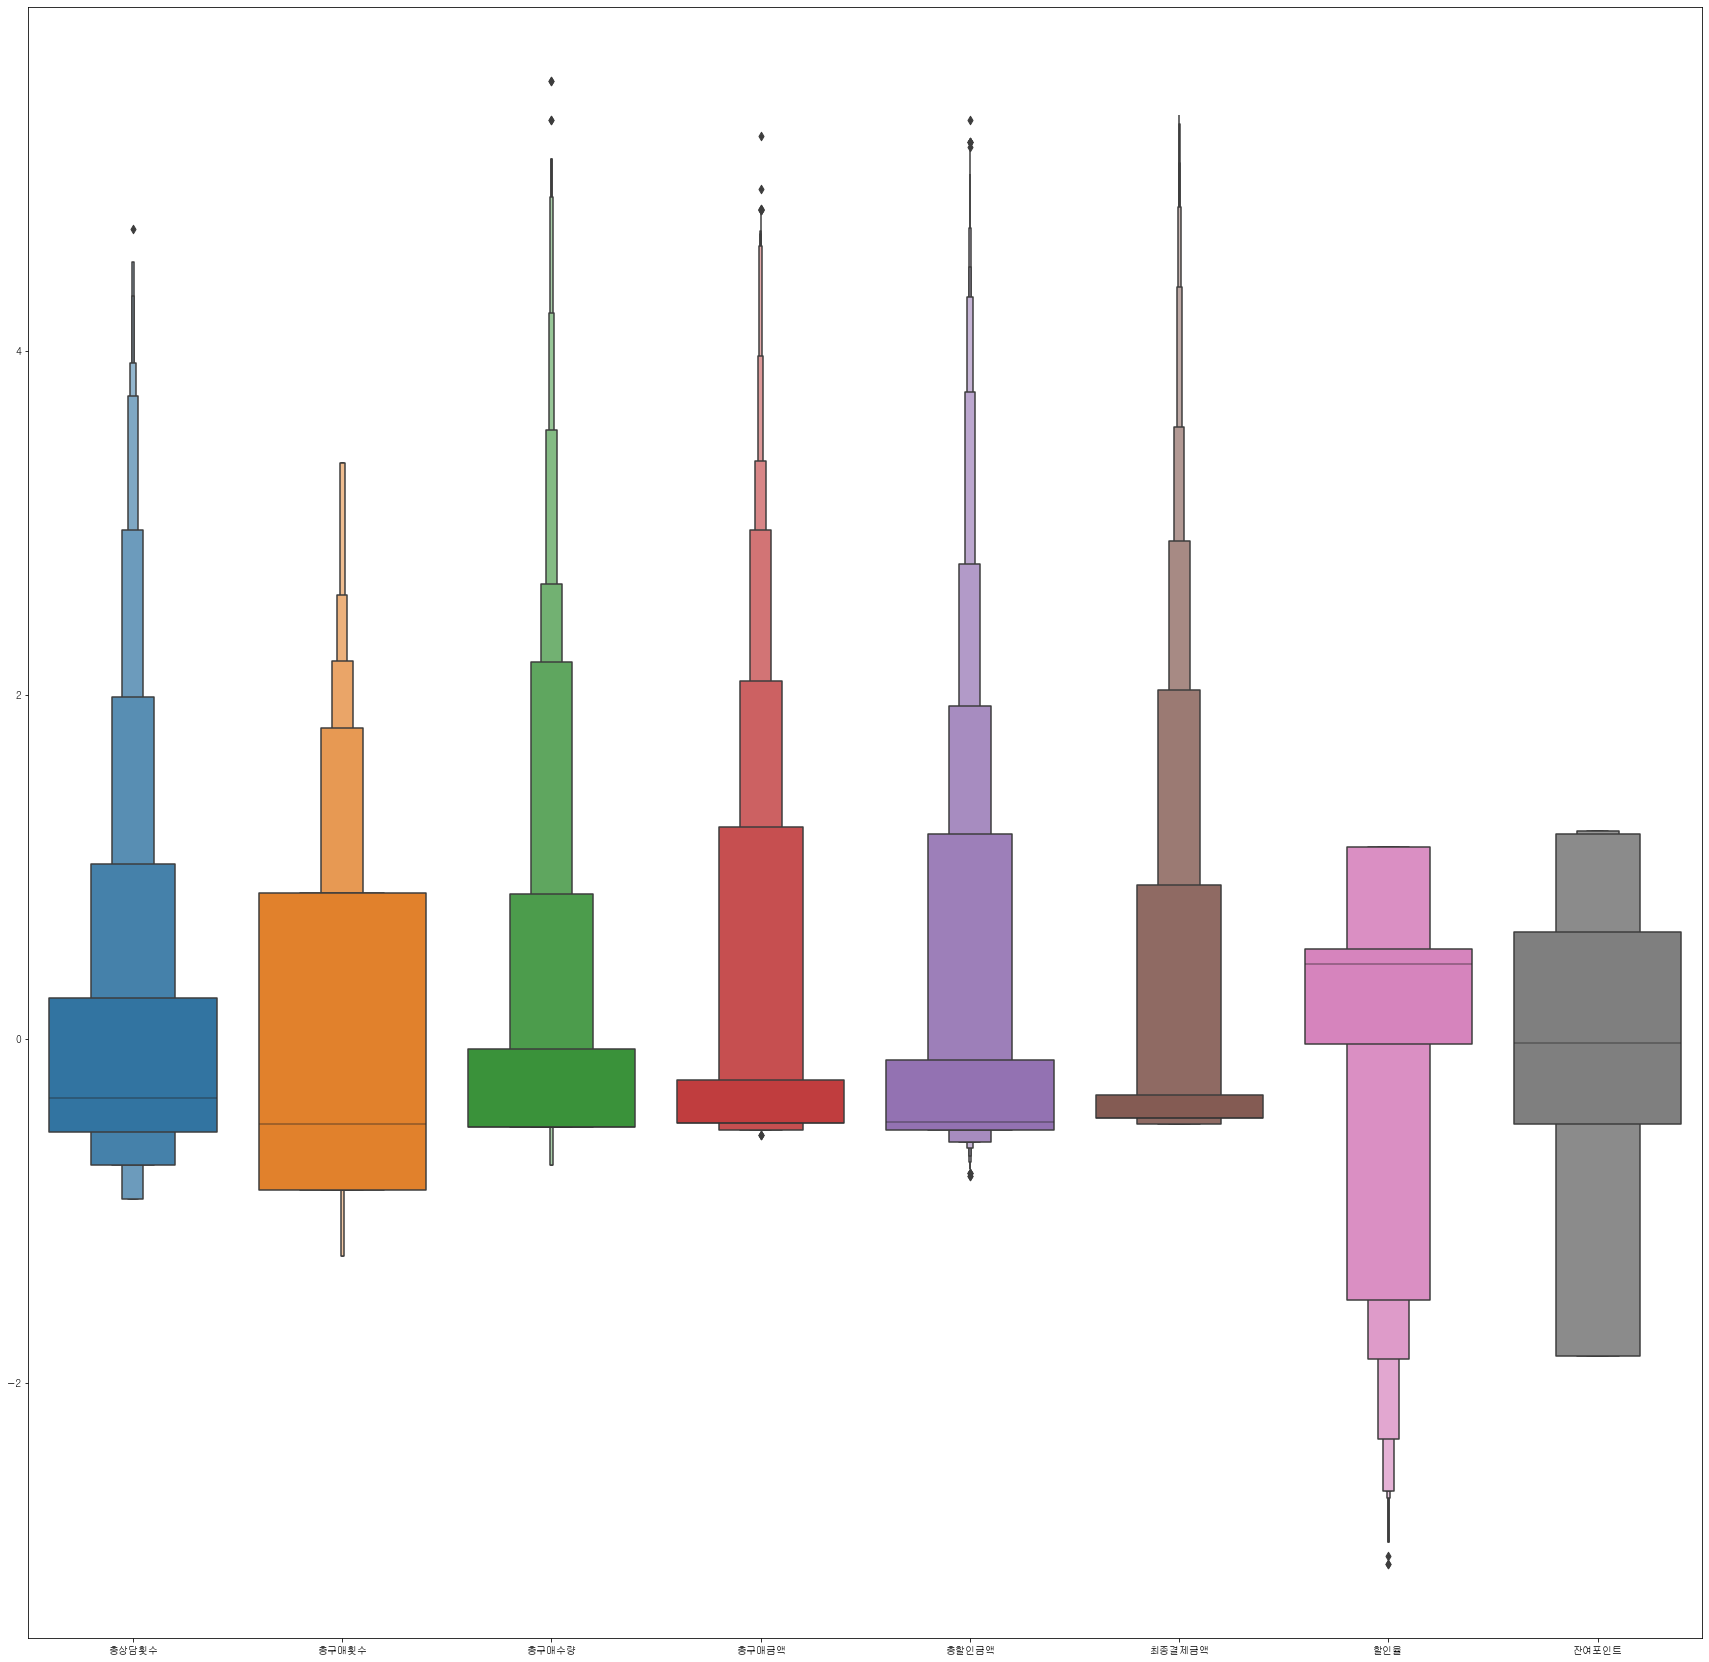

In [34]:
plt.figure(figsize=(30,30))
sns.boxenplot(data=train_x_data_num)

# Train the model

In [35]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

# 앙상블 기본 모델 학습 및 정확도 측정

In [36]:
clf_RFC = ensemble.RandomForestClassifier()
clf_RFC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_RFC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9360


In [37]:
clf_DTC = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_DTC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9193


# 부스팅 알고리즘 학습 및 정확도 측정

In [38]:
from xgboost import XGBClassifier

In [39]:
clf_XGB = XGBClassifier(random_state=0)
clf_XGB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_XGB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9323


In [40]:
clf_GB = ensemble.GradientBoostingClassifier()
clf_GB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_GB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9316


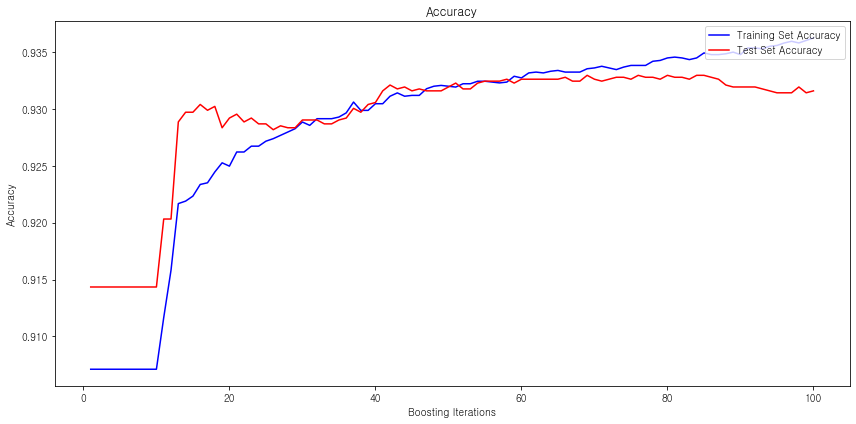

In [41]:
train_score = np.zeros((clf_GB.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB.staged_predict(x_train)):
    train_score[i] = accuracy_score(y_train, y_pred)

test_score = np.zeros((clf_GB.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB.staged_predict(x_test)):
    test_score[i] = accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') # Binomial deviance loss function for binary classification
plt.plot(np.arange(clf_GB.n_estimators) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(clf_GB.n_estimators) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

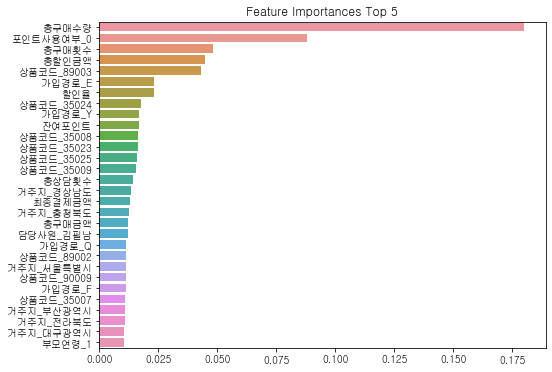

In [42]:
import seaborn as sns

feature_importance_values = clf_XGB.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [43]:
# x_data.to_excel("./x_data.xlsx")
# y_data.to_excel("./y_data.xlsx")

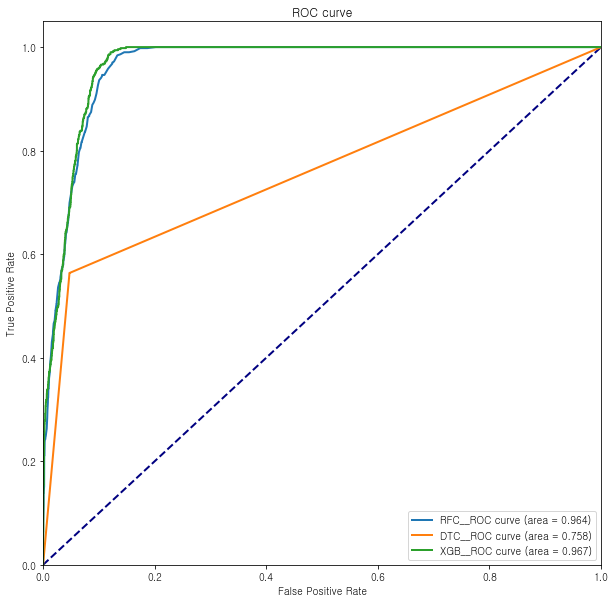

In [44]:
from sklearn.metrics import roc_curve, auc

models=['RFC', 'DTC', 'XGB']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Global 변수 (전역 변수)
# string으로 변수를 설정하고, 값을 할당의 목적으로 사용

for i in models:

    globals()['clf_{}_pred'.format(i)] = \
    globals()['clf_{}'.format(i)].predict_proba(x_test)
    
    globals()['clf_{}_roc'.format(i)]=\
    globals()['clf_{}_pred'.format(i)][:,1]
   
    globals()['fpr_{}'.format(i)],\
    globals()['tpr_{}'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['clf_{}_roc'.format(i)]) 
    
    globals()['roc_auc_{}'.format(i)] = \
    auc(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)])
    
    
    
    plt.plot(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}'.format(i)])


# # Stack model은 S_test data로 진행하므로 따로 정리함.
# clf_STACK_pred = clf_STACK_predict_proba(S_test)
# clf_STACK_roc = clf_STACK_pred[:,1]
# fpr_STACK, tpr_STACK, _STACK = roc_curve(y_true = y_test, y_score = clf_STACK_roc)
# roc_auc_STACK = auc(fpr_STACK, tpr_STACK)
# plt.plot(fpr_STACK, tpr_STACK, lw=2, label='STACK curve (area = %0.2f)'\
#          % roc_auc_STACK)


plt.legend()
plt.show()

In [45]:
from sklearn.metrics import classification_report

predictions = clf_XGB.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_XGB.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_XGB.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5359
           1       0.62      0.55      0.58       502

    accuracy                           0.93      5861
   macro avg       0.79      0.76      0.77      5861
weighted avg       0.93      0.93      0.93      5861

Accuracy on Training set: 0.979
Accuracy on Test set: 0.932


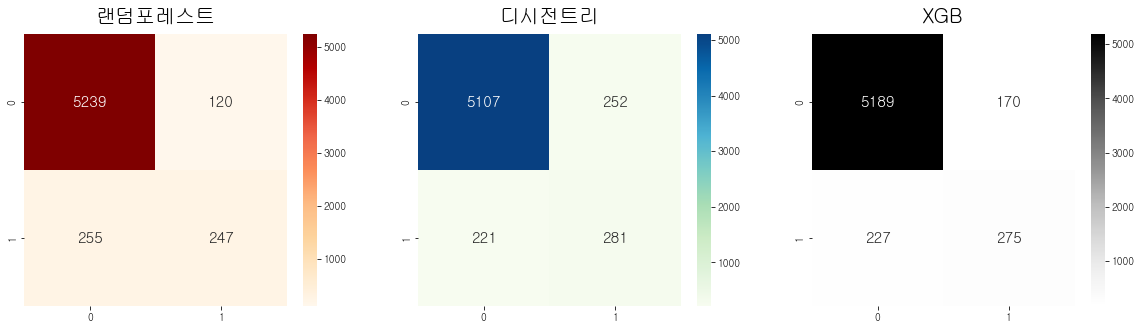

In [46]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_RFC.predict(x_test))
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_DTC.predict(x_test))
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_XGB.predict(x_test))


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('랜덤포레스트',pad = 12, fontsize = 20)
ax[1].set_title('디시전트리',pad = 12, fontsize = 20)
ax[2].set_title('XGB',pad = 12, fontsize = 20)
plt.show()

# 클래스 불균형 문제 해결(오버샘플링 SMOTE)

In [47]:
from imblearn.over_sampling import SMOTE

In [48]:
smote = SMOTE(random_state=42)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', x_train_over.shape, y_train_over.shape)
# print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_test.shape, y_test.shape)
print('SMOTE 적용 후 값의 분포 :\n', y_train_over.value_counts() )
#print('SMOTE 적용 후 값의 분포 :\n', y_train.value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (13674, 100) (13674, 1)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (24808, 100) (24808, 1)
SMOTE 적용 후 값의 분포 :
 재구매여부
0        12404
1        12404
dtype: int64


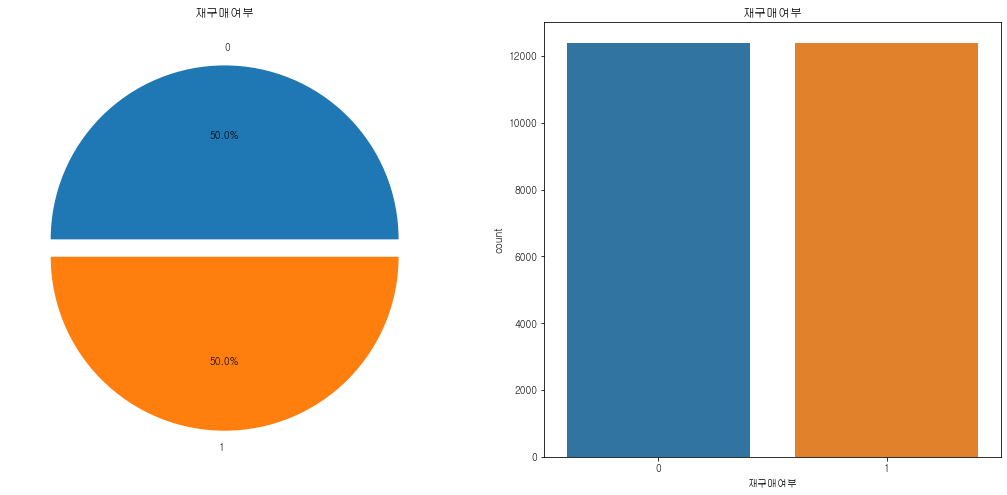

In [49]:
f, ax = plt.subplots(1,2,figsize=(18,8))
y_train_over['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = y_train_over, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

In [50]:
y_train_over['재구매여부'].value_counts()

0    12404
1    12404
Name: 재구매여부, dtype: int64

# 재학습

In [51]:
x_train_resample, x_test, y_train_resample, y_test =\
model_selection.train_test_split(x_train_over, y_train_over, test_size=0.3, random_state=0)

In [52]:
# params = {'n_estimators': 1000,
#           'max_depth': 5,
#           'min_samples_split': 7,
# #           'learning_rate': 0.01,
#          'random_state':0}

In [53]:
clf_Bagging_re = ensemble.BaggingClassifier()
clf_Bagging_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_Bagging_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9586


In [54]:
clf_RFC_re = ensemble.RandomForestClassifier()
clf_RFC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_RFC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9680


In [55]:
clf_DTC_re = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_DTC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9539


In [56]:
clf_XGB_re = XGBClassifier(random_state=0)
clf_XGB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9640


In [57]:
clf_GB_re = ensemble.GradientBoostingClassifier()
clf_GB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_GB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9492


In [72]:
x_train_resample

,거주지_강원도,거주지_경기도,거주지_경상남도,거주지_경상북도,거주지_광주광역시,거주지_대구광역시,거주지_대전광역시,거주지_부산광역시,거주지_서울특별시,거주지_세종특별자치시,...,포인트사용여부_0,포인트사용여부_1,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트
23379,0.000000,0.000000,0.0,0.0,0.0,0.131185,0.868815,0.0,0.0,0.0,...,1.0,0.0,1.453773,0.271323,0.839483,1.372202,2.181107,0.892724,-0.926161,-0.025540
8308,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,1.402764,0.271323,0.164136,0.510805,1.028661,0.226483,-0.756047,-0.025540
1919,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,-0.346973,-0.881829,-0.511210,-0.528785,-0.598857,-0.461966,0.222106,-0.025540
1243,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,-0.346973,0.847900,-0.511210,-0.490656,-0.532938,-0.439758,0.009464,0.618589
15889,0.001579,0.998421,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.819518,2.193244,2.192308,2.077230,1.965931,2.003914,-1.607488,1.186937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,-0.541388,-0.881829,-0.511210,-0.528785,-0.598857,-0.461966,0.222106,1.186937
19648,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.124514,0.271323,0.839483,1.232137,1.804349,0.876899,-1.065970,0.618589
9845,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,...,1.0,0.0,-0.541388,0.847900,-0.286095,-0.343589,-0.216982,-0.384238,0.009464,-1.844255
10799,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,...,1.0,0.0,-0.346973,0.847900,-0.511210,-0.490656,-0.487477,-0.461966,0.434748,-0.499164


In [58]:
# clf_XGB_re = XGBClassifier(
#                 colsample_bytree = 0.8,\
#                 gamma = 0.8,\
#                 learning_rate = 0.05,\
#                 max_depth = 25,\
#                 min_child_weight = 0.5,\
#                 n_estimators = 200,\
#                 nthread = -1,\
#                 objective = 'binary:logistic',\
#                 scale_pos_weight = 1,\
#                 seed = 2019,\
#                 subsample = 0.8)
# clf_XGB_re.fit(x_train_resample, y_train_resample)
# acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
# print("The accuracy score on test set: {:.4f}".format(acc))

In [59]:
# clf_XGB_re = XGBClassifier(
#                 colsample_bytree = 0.8,\
#                 gamma = 0,\
#                 learning_rate = 0.05,\
#                 max_depth = 25,\
#                 min_child_weight = 0.5,\
#                 n_estimators = 200,\
#                 nthread = -1,\
#                 objective = 'binary:logistic',\
#                 scale_pos_weight = 1,\
#                 seed = 2019,\
#                 subsample = 0.8)
# clf_XGB_re.fit(x_train_resample, y_train_resample)
# acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
# print("The accuracy score on test set: {:.4f}".format(acc))

In [60]:
predictions = clf_RFC_re.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_RFC_re.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_RFC_re.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3732
           1       0.95      0.98      0.97      3711

    accuracy                           0.97      7443
   macro avg       0.97      0.97      0.97      7443
weighted avg       0.97      0.97      0.97      7443

Accuracy on Training set: 0.982
Accuracy on Test set: 0.968


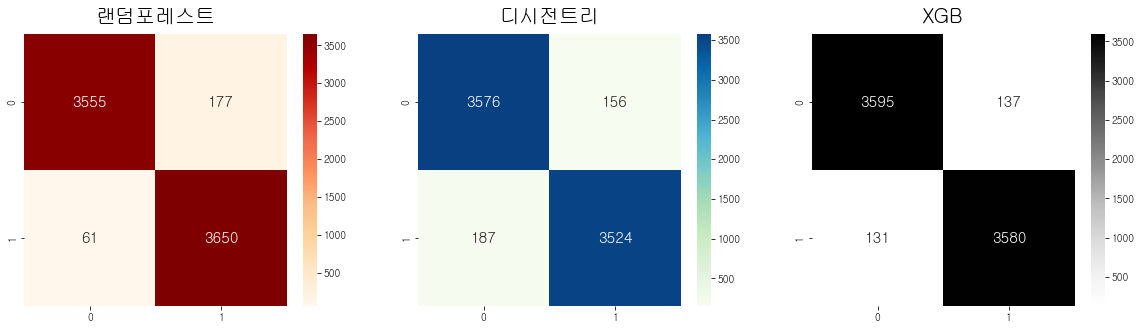

In [61]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_RFC_re.predict(x_test))
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_DTC_re.predict(x_test))
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_XGB_re.predict(x_test))


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('랜덤포레스트',pad = 12, fontsize = 20)
ax[1].set_title('디시전트리',pad = 12, fontsize = 20)
ax[2].set_title('XGB',pad = 12, fontsize = 20)
plt.show()

In [62]:
# import seaborn as sns

# feature_importance_values = clf_DTC_re.feature_importances_
# # Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
# feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# # 중요도값 순으로 Series를 정렬
# feature_top5 = feature_importances.sort_values(ascending=False)[:30]

# plt.figure(figsize=[8, 6])
# plt.title('DTC Feature Importances')
# sns.barplot(x=feature_top5, y=feature_top5.index)
# plt.show()

In [63]:
# import seaborn as sns

# feature_importance_values = clf_RFC_re.feature_importances_
# # Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
# feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# # 중요도값 순으로 Series를 정렬
# feature_top5 = feature_importances.sort_values(ascending=False)[:30]

# plt.figure(figsize=[8, 6])
# plt.title('RF Feature Importances')
# sns.barplot(x=feature_top5, y=feature_top5.index)
# plt.show()

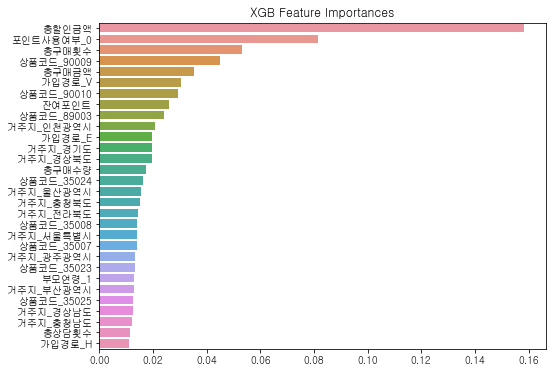

In [64]:
import seaborn as sns

feature_importance_values = clf_XGB_re.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=[8, 6])
plt.title('XGB Feature Importances')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [65]:
feature_top5

총할인금액         0.158446
포인트사용여부_0     0.081700
총구매횟수         0.053119
상품코드_90009    0.044931
총구매금액         0.035309
가입경로_V        0.030351
상품코드_90010    0.029303
잔여포인트         0.026116
상품코드_89003    0.024095
거주지_인천광역시     0.020947
가입경로_E        0.019813
거주지_경기도       0.019688
거주지_경상북도      0.019554
총구매수량         0.017283
상품코드_35024    0.016258
거주지_울산광역시     0.015420
거주지_충청북도      0.015153
거주지_전라북도      0.014468
상품코드_35008    0.014164
거주지_서울특별시     0.014038
상품코드_35007    0.013982
거주지_광주광역시     0.013271
상품코드_35023    0.013171
부모연령_1        0.013086
거주지_부산광역시     0.013062
상품코드_35025    0.012559
거주지_경상남도      0.012558
거주지_충청남도      0.012102
총상담횟수         0.011381
가입경로_H        0.011272
dtype: float32

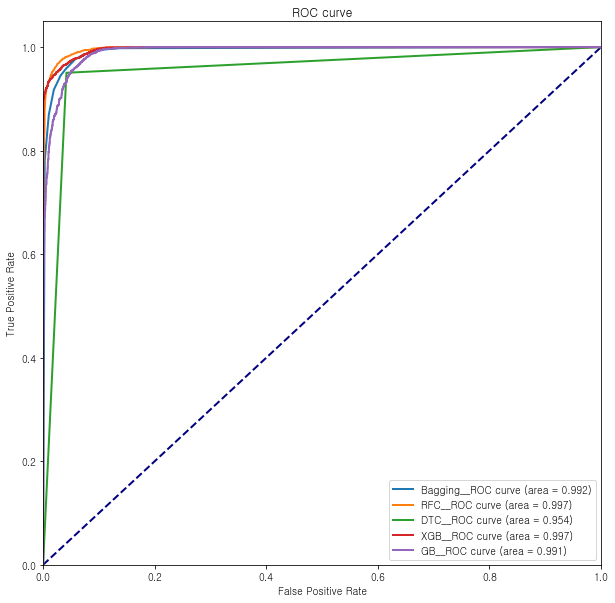

In [66]:
from sklearn.metrics import roc_curve, auc

models=['Bagging', 'RFC', 'DTC', 'XGB', 'GB']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


for i in models:

    globals()['clf_{}_re_pred'.format(i)] = \
    globals()['clf_{}_re'.format(i)].predict_proba(x_test)
    
    globals()['clf_{}_re_roc'.format(i)]=\
    globals()['clf_{}_re_pred'.format(i)][:,1]
   
    globals()['fpr_{}_re'.format(i)],\
    globals()['tpr_{}_re'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['clf_{}_re_roc'.format(i)]) 
    
    globals()['roc_auc_{}_re'.format(i)] = \
    auc(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)])

    
    plt.plot(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}_re'.format(i)])

plt.legend()
plt.show()

In [67]:
# from sklearn.metrics import roc_curve, auc

# models=['RFC', 'DTC', 'XGB']


# plt.figure(figsize=(10, 10))
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# plt.title("ROC curve")
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# for i in models:

#     globals()['clf_{}_re_pred'.format(i)] = \
#     globals()['clf_{}_re'.format(i)].predict_proba(x_test)
    
#     globals()['clf_{}_re_roc'.format(i)]=\
#     globals()['clf_{}_re_pred'.format(i)][:,1]
   
#     globals()['fpr_{}_re'.format(i)],\
#     globals()['tpr_{}_re'.format(i)], \
#     globals()['_{}'.format(i)] \
#     =roc_curve(y_true=y_test, y_score=globals()['clf_{}_re_roc'.format(i)]) 
    
#     globals()['roc_auc_{}_re'.format(i)] = \
#     auc(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)])

    
#     plt.plot(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)]
#              , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}_re'.format(i)])

# plt.legend()
# plt.show()

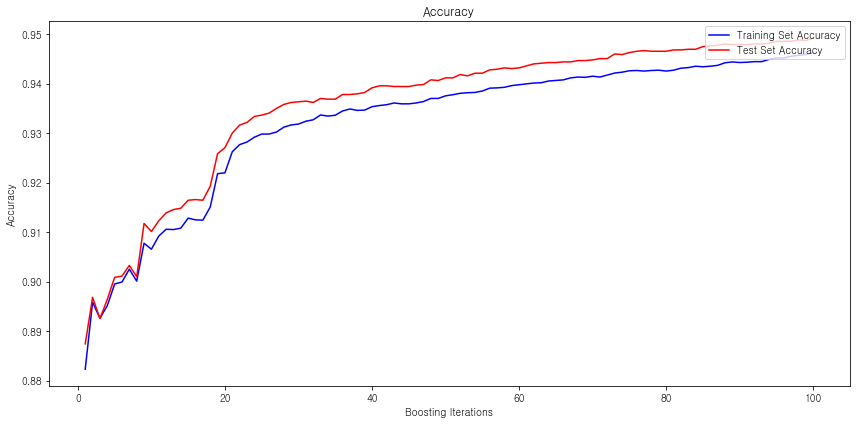

In [68]:
train_score = np.zeros((clf_GB_re.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB_re.staged_predict(x_train_resample)):
    train_score[i] = accuracy_score(y_train_resample, y_pred)

test_score = np.zeros((clf_GB_re.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB_re.staged_predict(x_test)):
    test_score[i] = accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') 
plt.plot(np.arange(clf_GB_re.n_estimators) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(clf_GB_re.n_estimators) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()